makemore: becoming a backprop ninja

In [191]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [192]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [193]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [194]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [195]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [196]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [197]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
Xb.shape

torch.Size([32, 3])

In [198]:
emb = C[Xb] # [32, 3, 10]
embcat = emb.view(emb.shape[0], -1) # [32, 30]

# Linear 1 
hprebn = embcat @ W1 + b1 # [32, 64]

# Batch norm 
bnmeani = 1/n * hprebn.sum(0, keepdim=True) # [1, 64]
bndiff = hprebn - bnmeani # [32, 64]
bndiff2 = bndiff**2 # [32, 64]
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)  # [1, 64] bessels
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)

# Linear 2 
logits = h @ W2 + b2 # [32, 27]

# Cross entropy loss same as F.cross_entropy(logits, Yb)
logit_maxes = logits.max(1, keepdim=True).values # [32, 1]
norm_logits = logits - logit_maxes # [32, 27]
counts = norm_logits.exp() # [32, 27]
counts_sum = counts.sum(1, keepdims=True) # [32, 1]
counts_sum_inv = counts_sum**-1 # [32, 1]
probs = counts * counts_sum_inv # [32, 27]
logprobs = probs.log() # [32, 27]
loss = -logprobs[range(n), Yb].mean() # [32] -> (1,)

# PyTorch 
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3186, grad_fn=<NegBackward0>)

In [199]:
dlogit_maxes # Should be zero does not affect the probs, only it helps
# with the exp to not overflow 
# change logit_maxes not affect 

tensor([[-1.8626e-09],
        [-3.7253e-09],
        [ 0.0000e+00],
        [-2.3283e-09],
        [-1.0245e-08],
        [ 4.6566e-10],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-5.1223e-09],
        [ 2.7940e-09],
        [-2.7940e-09],
        [ 1.8626e-09],
        [-5.5879e-09],
        [-3.2596e-09],
        [-2.0955e-09],
        [ 4.6566e-10],
        [-4.6566e-10],
        [-9.3132e-10],
        [-1.8626e-09],
        [-2.3283e-09],
        [ 0.0000e+00],
        [ 4.6566e-10],
        [-5.5879e-09],
        [-1.3970e-09],
        [ 1.8626e-09],
        [-4.1910e-09],
        [-2.0955e-09],
        [ 1.6298e-09],
        [ 0.0000e+00],
        [ 2.3283e-09],
        [-6.0536e-09],
        [-9.3132e-10]], grad_fn=<SumBackward1>)

In [200]:
dlogprobs = torch.zeros_like(logprobs) 
dlogprobs[range(n), Yb] = -1.0/n 

dprobs = (1.0/probs) * dlogprobs
# probs -> 1 dlogprobs passes
# probs -> less -> dlogprobs bost the examples 

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # Due to proadcasting

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

# Used twice 
# Sum -> 1 
# Addition -> router 
# Just takes the upper grad equallt 
dcounts = counts_sum_inv * dprobs # Will broadcast ok 
dcounts += torch.ones_like(counts) * dcounts_sum # Use broadcasting


dnorm_logits = counts * dcounts 
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True) # [32, 1]
# a11 a12 a13 - b1 
# a21 a22 a23 - b2
#== a11 - b1, a12 - b1, a13 - b1

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = dbnraw * bnvar_inv 
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)

dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

dbndiff2 = (1.0 / (n-1))* torch.ones_like(bndiff2) * dbnvar


dbndiff += (2 * bndiff) * dbndiff2

dhprebn = dbndiff.clone()
dbnmeani = (-1 * dbndiff).sum(0, keepdim=True)

dhprebn += (1.0/n)*torch.ones_like(hprebn) * dbnmeani


dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)

demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j] 

# For each occurance addition 
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)

cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)

cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

cmp('hpreact', dhpreact, hpreact)

cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)

cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
# "batchnorm" pytorch bug train biased
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

cmp('emb', demb, emb)
cmp('C', dC, C)

"""



"""

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

'\n\n\n\n'

In [201]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3185603618621826 diff: 0.0


In [202]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n # due to mean in forward  

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


In [207]:
F.softmax(logits, 1)[0]

tensor([0.0807, 0.0832, 0.0188, 0.0488, 0.0190, 0.0782, 0.0259, 0.0398, 0.0192,
        0.0287, 0.0368, 0.0362, 0.0343, 0.0271, 0.0354, 0.0142, 0.0107, 0.0199,
        0.0160, 0.0538, 0.0515, 0.0239, 0.0243, 0.0685, 0.0583, 0.0240, 0.0229],
       grad_fn=<SelectBackward0>)

In [208]:
dlogits[0] * n

tensor([ 0.0807,  0.0832,  0.0188,  0.0488,  0.0190,  0.0782,  0.0259,  0.0398,
        -0.9808,  0.0287,  0.0368,  0.0362,  0.0343,  0.0271,  0.0354,  0.0142,
         0.0107,  0.0199,  0.0160,  0.0538,  0.0515,  0.0239,  0.0243,  0.0685,
         0.0583,  0.0240,  0.0229], grad_fn=<MulBackward0>)

In [209]:
dlogits[0].sum() # -> 0 force 
# Pull up in the correct 
# Down the others 
# zero and 1 -> so dlogits all zero 
# Each update to logits proportional to probs 
# Push up the correct by x push down the incorrect by x (dist equally)

tensor(4.1910e-09, grad_fn=<SumBackward0>)

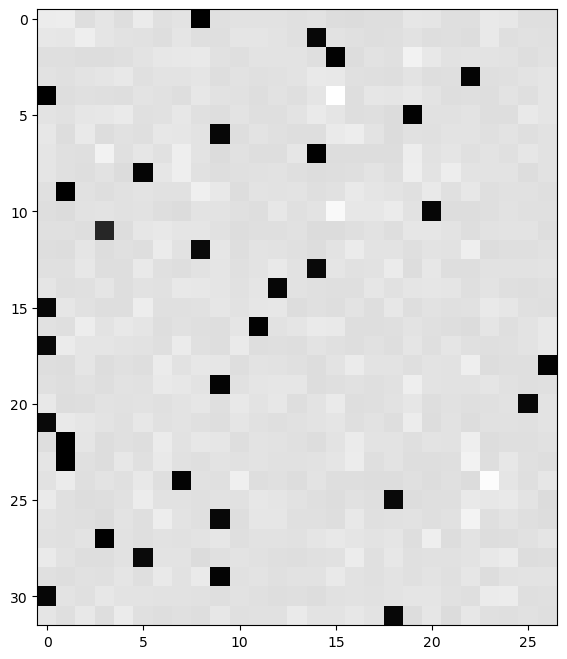

In [206]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [210]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [215]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = (bngain * bnvar_inv / n) * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact *  bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my 

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape


In [226]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# bn
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():
    
    for i in range(max_steps):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        
           # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer 
        
        loss = F.cross_entropy(logits, Yb)
        
        for p in parameters:
            p.grad = None
        #loss.backward()
        
            # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
          for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
            #p.data += -lr * p.grad
            
        
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        #if i >= 100: # TODO: delete early breaking when you're ready to train the full net
        #    break


12297
      0/ 200000: 3.8357
  10000/ 200000: 2.1331
  20000/ 200000: 2.3847
  30000/ 200000: 2.5135
  40000/ 200000: 1.9986
  50000/ 200000: 2.4013
  60000/ 200000: 2.3614
  70000/ 200000: 2.0778
  80000/ 200000: 2.3392
  90000/ 200000: 2.1420
 100000/ 200000: 1.9909
 110000/ 200000: 2.2906
 120000/ 200000: 2.0848
 130000/ 200000: 2.4244
 140000/ 200000: 2.2947
 150000/ 200000: 2.2507
 160000/ 200000: 1.9392
 170000/ 200000: 1.7469
 180000/ 200000: 1.9709
 190000/ 200000: 1.8727


In [ ]:
"""for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)"""

In [227]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)
    


In [229]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y ={
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
    
    
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695741176605225
val 2.1080949306488037


In [233]:
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    
    while True:
        
        emb = C[torch.tensor([context])]
        
        embcat = emb.view(emb.shape[0], -1)
        
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carmah.
amille.
khyrin.
xhentleena.
sane.
mahnen.
deliah.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinn.
shon.
marianni.
waterri.
jaryxia.
kaellissabee.
deci.
